In [90]:
import bs4
from selenium import webdriver
import requests
import unidecode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')


In [91]:
# This is the dataframe that we are going to be populating as we scrape the data
foo = pd.DataFrame(columns = ['full_name', 'party', 'number', 'chamber', 'DOB'])


In [92]:

# We will want to get congress no 65-101 inclusive for the house, and 65-79 inclusive for the senate
# Create a dictionary that specifies to search for these things for the different congresses
options = {}

for i in range(80, 102):
    options[i] = ['house']
    
for i in range(65, 80):
    options[i] = ['house', 'senate']

In [93]:

# Start your browser and navigate to the page of interest

browser = webdriver.Firefox(executable_path='/Users/tchavas/geckodriver')


translation = {'house': 'option[2]' , 'senate': 'option[3]'}
# These options allow to search for members of the congress or members of the senate separately
# in the for loop below


# Change the range of this for loop to look up the different congresses
for congress_number in range(65, 102):



    for c in options[congress_number]:
        # Navigate to the page of interest
        browser.get('http://bioguide.congress.gov/biosearch/biosearch.asp')
        # Find the dropdown menu to select the chamber and input
        rep_field = browser.find_element_by_xpath('/html/body/center/form/table/tbody/tr[3]/td[2]/select/' \
                                                  + translation[c]).click()
        

        # Find the input box for congress number and put in the one of interest
        year_field = browser.find_element_by_xpath('/html/body/center/form/table/tbody/tr[6]/td[2]/input')
        year_field.send_keys(congress_number)
        
        
        # Submit the form
        browser.find_element_by_xpath('/html/body/center/form/input[1]').click()

        # Now take all the info from the page that we've navigated to, and find all the table rows <tr>
        html = browser.page_source
        data = bs4.BeautifulSoup(html, 'html.parser').find_all('tr')
        
        # We now need to parse all the relevant information from the page into arrays that will then be 
        # put into a single temporary dataframe
        
        names = []
        party = []
        number = []
        chamber = []
        DOB = []
        
        for element in data[2:]:
            names.append(element.find_all('td')[0].text)
            party.append(element.find_all('td')[3].text)
            number.append(congress_number)
            chamber.append(c)
            DOB.append(element.find_all('td')[1].text.split('-')[0])


        # Create an empty temporary dataframe
        temp = pd.DataFrame(columns = ['full_name', 'party', 'number', 'chamber', 'DOB'])
        # Populate with the arrays from this iteration of the for loop
        temp.full_name, temp.party, temp.number, temp.chamber, temp.DOB = \
        names, party, congress_number, chamber, DOB

        # Now append this temporary dataframe to the master one, foo
        foo = foo.append(temp, ignore_index = True, sort = False)



In [95]:
# We now have all the data that we need
foo.head(10)
foo.shape

(18133, 5)

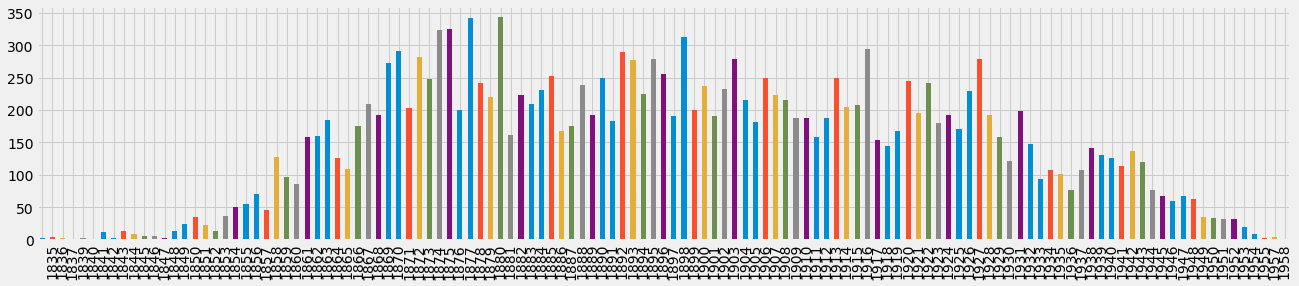

In [97]:
foo.DOB.value_counts(dropna= False).sort_index().plot(kind = 'bar', figsize = (20, 4))

In [98]:
# We now need to extract the first name from the full_name column
# Let's define a function to do that


def stem_first_name(full_name):
    # Some names have accents/special characters, need to remove that if we want the gender prediction
    # algorithm in R to function properly
    try:
        first = unidecode.unidecode(full_name.split(',')[1].strip())
    except:
        return full_name

    # Take the word immediately after the first comma, unless that first word has a full stop
    for word in first.split(' '):
        if '.' not in word:
            return word
        
# Apply the function to the dataframe

foo['first_name'] = foo['full_name'].apply(stem_first_name)
foo.head()

,full_name,party,number,chamber,DOB,first_name
0,"ADAMSON, William Charles",Democrat,65,house,1854,William
1,"ALEXANDER, Joshua Willis",Democrat,65,house,1852,Joshua
2,"ALMON, Edward Berton",Democrat,65,house,1860,Edward
3,"ANDERSON, Sydney",Republican,65,house,1881,Sydney
4,"ANTHONY, Daniel Read, Jr.",Republican,65,house,1870,Daniel


In [154]:
# Let's leave the DOB as it is, and create a new column in the dataframe that corresponds to 
# the method that the gender function will use. 'ipums' is more accurate for older DOBs (i.e. pre-1930)
# 'ssa' will be used for post-1930
foo['DOB'] = pd.to_numeric(foo.DOB)
foo['method'] = foo['DOB'].apply(lambda x: 'ssa' if x >= 1930 else 'ipums')

In [155]:
foo.method.value_counts(dropna=False)

ipums    15907
ssa       2223
Name: method, dtype: int64

In [116]:
foo.full_name.isna().value_counts()

False    18130
Name: full_name, dtype: int64

In [114]:
# Before we convert anything, let's check if we have any missing dates of birth

foo[foo.DOB.isna() == True]

# We have three missing dates of birth. This is because of senators or representatives that change party during
# congress. Let's drop these rows

foo.drop(foo[foo.DOB.isna() == True].index, inplace=True)

In [119]:
len(foo)

18130

In [120]:
# Transfer the dataframe to R 
foo.to_csv('foo.csv')

In [167]:
# R commands
# foo <- read.csv('foo.csv', stringsAsFactors = FALSE)

# The snippet below leads to a lot of duplicates generated, which means you get way more rows than you should
# when you merge back with the original df
##### > test <- foo %>% rowwise() %>% do(results = gender(.$first_name, years = .$DOB, method = .$method)) 
##### %>% do(bind_rows(.$results))

# > write.csv(test, 'results_congress.csv')

# We'll need to drop some duplicates later, otherwise the merging will generate a 1e5 rows.

bar = pd.read_csv('results_congress.csv', index_col = 0)

In [168]:
len(bar)

17547

In [169]:
# How many women are there, with not super high confidence? 
len(bar[(bar.gender == 'female') & (bar.proportion_female < 0.85)])
# 173

173

In [170]:
bar[(bar.name == 'William') & (bar.year_min == 1854)]

,name,proportion_male,proportion_female,gender,year_min,year_max
1,William,0.9986,0.0014,male,1854,1854
550,William,0.9986,0.0014,male,1854,1854
1087,William,0.9986,0.0014,male,1854,1854
1093,William,0.9986,0.0014,male,1854,1854
1149,William,0.9986,0.0014,male,1854,1854


In [171]:
# How many women are there, with 95% high confidence

len(bar[(bar.gender == 'female') & (bar.proportion_female > 0.95)])

# 441

416

In [173]:
bar.head()

,name,proportion_male,proportion_female,gender,year_min,year_max
1,William,0.9986,0.0014,male,1854,1854
2,Joshua,1.0000,0.0000,male,1852,1852
3,Edward,0.9917,0.0083,male,1860,1860
4,Sydney,0.3247,0.6753,female,1881,1881
5,Daniel,1.0000,0.0000,male,1870,1870


In [174]:
# Dropping duplicates that were generated by the R function previously
bar.drop_duplicates(subset = ['name', 'year_min', 'proportion_male'], inplace= True)

18130

In [175]:
# We have quite a few duplicates in bar, need to check if we can remove those. 
len(bar)

2720

In [144]:
foo.shape[0] #- bar.shape[0]

18130

In [176]:
# We can drop the year_min column (same as year_max), and rename the year_max to DOB and use that to merge
bar.drop('year_min', axis = 1, inplace= True)
bar.rename(columns = {'year_max': 'DOB', 'name' : 'first_name', 'gender' : 'predicted_gender'}
                         , inplace = True)
# Also want to change 'male' to 'M' and 'female' to 'F'
bar.replace({'predicted_gender' : {'male': 'M', 'female' : 'F'}}, inplace = True)

In [177]:
bar[(bar.first_name == 'William') & (bar.DOB == 1854)]

,first_name,proportion_male,proportion_female,predicted_gender,DOB
1,William,0.9986,0.0014,M,1854


2720

In [178]:
# Now merge back and then we'll inspect the possible false positives/false negatives

final = foo.merge(bar, on = ['first_name', 'DOB'], how = 'outer')
final.head(10)

,full_name,party,number,chamber,DOB,first_name,method,proportion_male,proportion_female,predicted_gender
0,"ADAMSON, William Charles",Democrat,65,house,1854.0,William,ipums,0.9986,0.0014,M
1,"ANDREWS, William Ezekiel",Republican,66,house,1854.0,William,ipums,0.9986,0.0014,M
2,"ANDREWS, William Ezekiel",Republican,67,house,1854.0,William,ipums,0.9986,0.0014,M
3,"ATKESON, William Oscar",Republican,67,house,1854.0,William,ipums,0.9986,0.0014,M
4,"COCKRAN, William Bourke",Democrat,67,house,1854.0,William,ipums,0.9986,0.0014,M
5,"ALEXANDER, Joshua Willis",Democrat,65,house,1852.0,Joshua,ipums,1.0000,0.0000,M
6,"ALEXANDER, Joshua Willis",Democrat,66,house,1852.0,Joshua,ipums,1.0000,0.0000,M
7,"ALMON, Edward Berton",Democrat,65,house,1860.0,Edward,ipums,0.9917,0.0083,M
8,"ROBBINS, Edward Everett",Republican,65,house,1860.0,Edward,ipums,0.9917,0.0083,M
9,"SAUNDERS, Edward Watts",Democrat,65,house,1860.0,Edward,ipums,0.9917,0.0083,M


In [179]:
# Are we missing genders? 
final.predicted_gender.isna().value_counts()
# We're missing genders for 29 of the 2506 members
# We're missing 583 genders for the dataset of 18130 rows

# Perhaps there are just a few of them? 
#final[final.predicted_gender.isna() == True]

False    17547
True       583
Name: predicted_gender, dtype: int64

In [198]:
# Let's check if there are any members that were predicted to be women,
# who have a lower probability of being female (< 0.90)
set(final[(final.proportion_female < 0.90) & (final.predicted_gender == 'F')].full_name)
# 36 names. Of those 36 names, only 7 are female. That's a lot of false postives. 

{'ANDERSON, Sydney',
 'ANTHONY, Beryl Franklin, Jr.',
 'BENET, Christie',
 'BENNETT, Marion Tinsley',
 'BUNKER, Berkeley Lloyd',
 'CASE, Francis Higbee',
 'CLARKE, Marian Williams',
 'CONDON, Francis Bernard',
 'DECKER, Perl D.',
 'DUFFY, Francis Ryan',
 'ESLICK, Willa McCord Blake',
 'FENERTY, Clare Gerald',
 'HAMLIN, Courtney Walker',
 'HOFFMAN, Clare Eugene',
 'HONEYMAN, Nan Wood',
 'JAMES, Ollie Murray',
 'KELLEY, Augustine Bernard',
 'LONERGAN, Augustine',
 'LUCE, Clare Boothe',
 'MAGEE, Clare',
 'MAIN, Verner Wright',
 'MALONEY, Francis Thomas',
 'MINK, Patsy Takemoto',
 'OLDFIELD, Pearl Peden',
 'ROTH, Toby A.',
 'SEIBERLING, Francis',
 'SHOEMAKER, Francis Henry',
 'SNYDER, Marion Gene',
 'SUMNER, Jessie',
 'SWANSON, Claude Augustus',
 'UNDERWOOD, Mell Gilbert',
 'VINCENT, Bird J.',
 'WALTER, Francis Eugene',
 'WARE, Orie Solomon',
 'WHITTEN, Jamie Lloyd',
 'ZIONCHECK, Marion Anthony'}

In [220]:
# We're going to change that back to male, and then amend those that are actually women:
final.loc[(final.proportion_female < 0.90) & (final.predicted_gender == 'F'), 'predicted_gender'] = 'M'

In [241]:
# Painstakingly change the gender of those 7 women back to female
final.loc[final.full_name.str.contains('ESLICK, Willa'), 'predicted_gender'] = 'F'
final.loc[final.full_name.str.contains('CLARKE, Marian'), 'predicted_gender'] = 'F'
final.loc[final.full_name.str.contains('HONEYMAN, Nan'), 'predicted_gender'] = 'F'
final.loc[final.full_name.str.contains('LUCE, Clare'), 'predicted_gender'] = 'F'
final.loc[final.full_name.str.contains('MINK, Patsy'), 'predicted_gender'] = 'F'
final.loc[final.full_name.str.contains('SUMNER, Jessie'), 'predicted_gender'] = 'F'
final.loc[final.full_name.str.contains('OLDFIELD, Pearl'), 'predicted_gender'] = 'F'

In [243]:
# We have now caught all 29 false positives, that had a probability of being female above 0.9
# Interesting, but how many unknowns do we actually have? 
final.predicted_gender.isna().value_counts()
# Approximately 3.2%. Remember, an unknown is better than a false positive

False    17547
True       583
Name: predicted_gender, dtype: int64

In [245]:
final[(final.proportion_female < 0.85) & (final.proportion_female > 0.5) & (final.predicted_gender == 'M')]

,full_name,party,number,chamber,DOB,first_name,method,proportion_male,proportion_female,predicted_gender
19,"ANDERSON, Sydney",Republican,65,house,1881.0,Sydney,ipums,0.3247,0.6753,M
20,"ANDERSON, Sydney",Republican,66,house,1881.0,Sydney,ipums,0.3247,0.6753,M
21,"ANDERSON, Sydney",Republican,67,house,1881.0,Sydney,ipums,0.3247,0.6753,M
22,"ANDERSON, Sydney",Republican,68,house,1881.0,Sydney,ipums,0.3247,0.6753,M
879,"DECKER, Perl D.",Democrat,65,house,1875.0,Perl,ipums,0.4834,0.5166,M
1483,"HAMLIN, Courtney Walker",Democrat,65,house,1858.0,Courtney,ipums,0.4947,0.5053,M
1934,"LONERGAN, Augustine",Democrat,65,house,1874.0,Augustine,ipums,0.4795,0.5205,M
1935,"LONERGAN, Augustine",Democrat,66,house,1874.0,Augustine,ipums,0.4795,0.5205,M
1936,"LONERGAN, Augustine",Democrat,72,house,1874.0,Augustine,ipums,0.4795,0.5205,M
1937,"LONERGAN, Augustine",Democrat,73,senate,1874.0,Augustine,ipums,0.4795,0.5205,M


In [248]:
# Let's save this motherfucking dataset

final.to_csv('congress_final.csv')